In [1]:
import tensorflow as tf
tf.__version__
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10930283995159927648,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14111382884033455346
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6918604064
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11832771042838820579
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14581556752750596317
 physical_device_desc: "device: XLA_GPU device"]

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [3]:
tf.debugging.set_log_device_placement(True)

a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)
print(c)

Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [4]:
import keras
from keras.models import Sequential, Model
from keras import layers, applications, optimizers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random

In [5]:
epoch = 100
batch_size = 5
image_size = 224

In [6]:
#load train data(25000 imgs each)

filenames = os.listdir('./input/train/train')
data = []
categories = []

for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
    
    image = load_img(os.path.join('./input/train/train', filename),  color_mode='rgb', target_size=(image_size,image_size))
    image = np.array(image)
    data.append(image)

data = np.array(data)
categories = np.array(categories)

print(data)
print(categories)

[[[[203 164  87]
   [206 167  90]
   [209 170  93]
   ...
   [245 203 119]
   [241 202 123]
   [239 200 121]]

  [[203 164  87]
   [206 167  90]
   [209 170  93]
   ...
   [245 205 120]
   [242 203 124]
   [240 201 122]]

  [[203 164  87]
   [206 167  90]
   [209 170  93]
   ...
   [245 204 122]
   [243 204 125]
   [241 202 123]]

  ...

  [[154 123  56]
   [155 124  57]
   [156 125  58]
   ...
   [  3   3   1]
   [  3   3   1]
   [  3   3   1]]

  [[153 122  55]
   [153 122  55]
   [154 123  56]
   ...
   [  2   2   0]
   [  2   2   0]
   [  2   2   0]]

  [[151 120  53]
   [152 121  54]
   [153 122  55]
   ...
   [  1   1   0]
   [  1   1   0]
   [  1   1   0]]]


 [[[ 39  44  40]
   [ 40  44  43]
   [ 41  45  46]
   ...
   [210 209 181]
   [207 204 171]
   [201 199 161]]

  [[ 40  45  41]
   [ 40  44  43]
   [ 41  45  46]
   ...
   [207 203 176]
   [203 200 169]
   [197 195 157]]

  [[ 39  44  40]
   [ 38  42  41]
   [ 37  41  42]
   ...
   [195 191 166]
   [198 193 164]
   [205 200

In [7]:
# shuffle dataset

idx = np.random.permutation(len(data))
data, categories = data[idx], categories[idx]

In [8]:
# split train 6(15,000) / val 2(5,000) / test 2(5,000)

x_train = data[:15000]
y_train = categories[:15000]
x_temp, y_temp = data[-10000:], categories[-10000:]

from sklearn.model_selection import train_test_split

x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5)

In [9]:
print(x_train, y_train)

print(x_temp, y_temp)
print(x_temp.shape, y_temp.shape)

print(x_val, y_val)

print(x_test, y_test)
print(x_test.shape, y_test.shape)

[[[[ 16  30   7]
   [105 107  96]
   [ 25  19  23]
   ...
   [ 74  77  68]
   [ 75  75  65]
   [ 73  73  63]]

  [[ 30  45  24]
   [ 88  91  82]
   [ 31  26  32]
   ...
   [ 66  68  57]
   [ 63  63  53]
   [ 61  61  51]]

  [[ 23  40  21]
   [104 107 100]
   [ 21  19  24]
   ...
   [ 68  70  59]
   [ 65  65  55]
   [ 63  63  53]]

  ...

  [[ 12  14  13]
   [  7   9   8]
   [  5   7   6]
   ...
   [ 35  29  17]
   [ 34  24  15]
   [ 30  20  11]]

  [[ 15  17  16]
   [ 12  14  13]
   [  5   7   6]
   ...
   [ 37  31  19]
   [ 37  27  18]
   [ 33  23  14]]

  [[ 13  15  12]
   [ 23  25  22]
   [  4   6   3]
   ...
   [ 38  31  15]
   [ 35  29  17]
   [ 33  27  15]]]


 [[[255 254 242]
   [  4   0   0]
   [255 255 245]
   ...
   [186 193 209]
   [192 199 218]
   [184 191 210]]

  [[ 16   9   3]
   [255 255 250]
   [  0   1   0]
   ...
   [186 193 209]
   [191 198 217]
   [184 191 210]]

  [[255 254 255]
   [  0   0   9]
   [  0   0  14]
   ...
   [184 191 207]
   [190 197 216]
   [184 191

In [10]:
# data augmentation in train set (train 15,000 to 75,000)

x_train_temp = x_train
y_train_temp = y_train

x_train_aug = []
y_train_aug = []

for img, label in zip(x_train_temp, y_train_temp):
    curImg = img
    
    flipped1 = tf.image.flip_left_right(curImg)
    flipped2 = tf.image.flip_up_down(curImg)
    
    x_train_aug.append(flipped1)
    x_train_aug.append(flipped2)
    
    for i in range(3):
        cropped = curImg[random.randrange(0,100):random.randrange(180,225), random.randrange(0,100):random.randrange(180,225)]
        cropped = cv2.resize(cropped, (image_size, image_size))
        x_train_aug.append(cropped)
    
    for i in range(0, 5):
        y_train_aug.append(label)
        
x_train_aug = np.array(x_train_aug)
y_train_aug = np.array(y_train_aug)

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReverseV2 in device /job:localhost/replica:0/task:0

In [11]:
x_train = np.concatenate((x_train, x_train_aug))
y_train = np.concatenate((y_train, y_train_aug))

In [12]:
print(x_train.shape)
print(y_train.shape)

(90000, 224, 224, 3)
(90000,)


In [13]:
def build_vgg_block(input_layer, num_cnn=3, channel=64, block_num=1):
    x = input_layer
    
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}')(x)

    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling')(x)

    return x

In [14]:
def build_vgg(input_shape=(image_size,image_size,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=2):
    input_layer = keras.layers.Input(shape=input_shape)
    output = input_layer
    
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
    )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', kernel_regularizer='l2', name='fc1')(output)
    output = keras.layers.Dropout(0.5)(output)
    output = keras.layers.Dense(4096, activation='relu', kernel_regularizer='l2', name='fc2')(output)
    output = keras.layers.Dropout(0.5)(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [15]:
%load_ext tensorboard

import datetime

In [16]:
model = build_vgg()

Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/re

Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localh

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/

In [17]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, clipnorm=1.),
    metrics=['accuracy']
)

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:lo

In [18]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 112, 112, 64)      0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 56, 56, 128)      

In [19]:
log_dir = "logs/vgg_da_new/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [20]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_checkpoint = ModelCheckpoint('vgg16.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [21]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)

In [22]:
epoch = 11

history = model.fit(
    x_train, y_train,
    epochs=epoch,
    validation_data=(x_val, y_val),
    #validation_steps=2500//batch_size,
    #steps_per_epoch=22500//batch_size,
    verbose=1,
    #callbacks=[tensorboard_callback, early_stopping, model_checkpoint]
    callbacks=[tensorboard_callback, reduce_lr]
)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SummaryWriter 

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device 

Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:loc

 105/2813 [>.............................] - ETA: 10:52 - loss: 118.8205 - accuracy: 0.5128Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 148/2813 [>.............................] - ETA: 10:42 - loss: 113.4784 - accuracy: 0.5148Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 191/2813 [=>............................] - ETA: 10:32 - loss: 108.1695 - accuracy: 0.5169Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 234/2813 [=>............................] - ETA: 10:22 - loss: 103.0215 - accuracy: 0.5183Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 277/2813 [=>............................] - ETA: 10:12 - loss: 97.9582 - accuracy: 0.5150Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 320/2813 [==>...........................] - ETA: 10:02 - loss: 93.0101 - accuracy: 0.5097Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 406/2813 [===>..........................] - ETA: 9:41 - loss: 83.6816 - accuracy: 0.5100Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 492/2813 [====>.........................] - ETA: 9:21 - loss: 75.3353 - accuracy: 0.5154Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 578/2813 [=====>........................] - ETA: 9:00 - loss: 68.0348 - accuracy: 0.5222Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 664/2813 [======>.......................] - ETA: 8:40 - loss: 61.6698 - accuracy: 0.5243Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 750/2813 [======>.......................] - ETA: 8:19 - loss: 56.1476 - accuracy: 0.5280Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 836/2813 [=======>......................] - ETA: 7:58 - loss: 51.3736 - accuracy: 0.5305Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 922/2813 [========>.....................] - ETA: 7:38 - loss: 47.2421 - accuracy: 0.5321Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1008/2813 [=========>....................] - ETA: 7:17 - loss: 43.6533 - accuracy: 0.5373Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1094/2813 [==========>...................] - ETA: 6:56 - loss: 40.5249 - accuracy: 0.5412Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1180/2813 [===========>..................] - ETA: 6:35 - loss: 37.7849 - accuracy: 0.5423Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1266/2813 [============>.................] - ETA: 6:15 - loss: 35.3714 - accuracy: 0.5455Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1352/2813 [=============>................] - ETA: 5:54 - loss: 33.2352 - accuracy: 0.5486Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1438/2813 [==============>...............] - ETA: 5:33 - loss: 31.3350 - accuracy: 0.5520Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1524/2813 [===============>..............] - ETA: 5:12 - loss: 29.6363 - accuracy: 0.5547Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1610/2813 [================>.............] - ETA: 4:51 - loss: 28.1099 - accuracy: 0.5576Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1696/2813 [=================>............] - ETA: 4:31 - loss: 26.7327 - accuracy: 0.5598Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1782/2813 [==================>...........] - ETA: 4:10 - loss: 25.4842 - accuracy: 0.5616Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1868/2813 [==================>...........] - ETA: 3:49 - loss: 24.3483 - accuracy: 0.5638Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1954/2813 [===================>..........] - ETA: 3:28 - loss: 23.3106 - accuracy: 0.5658Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2040/2813 [====================>.........] - ETA: 3:07 - loss: 22.3588 - accuracy: 0.5680Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2126/2813 [=====================>........] - ETA: 2:46 - loss: 21.4833 - accuracy: 0.5699Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2212/2813 [======================>.......] - ETA: 2:25 - loss: 20.6753 - accuracy: 0.5716Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2298/2813 [=======================>......] - ETA: 2:05 - loss: 19.9266 - accuracy: 0.5746Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2384/2813 [========================>.....] - ETA: 1:44 - loss: 19.2322 - accuracy: 0.5769Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2470/2813 [=========================>....] - ETA: 1:23 - loss: 18.5852 - accuracy: 0.5798Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2556/2813 [==========================>...] - ETA: 1:02 - loss: 17.9835 - accuracy: 0.5798Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2642/2813 [===========================>..] - ETA: 41s - loss: 17.4195 - accuracy: 0.5821Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2728/2813 [============================>.] - ETA: 20s - loss: 16.8908 - accuracy: 0.5840Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2813/2813 [==============================] - ETA: 0s - loss: 16.4023 - accuracy: 0.5863Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0


Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CreateSummaryFileWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing 

Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:l

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

 102/2813 [>.............................] - ETA: 10:54 - loss: 0.6355 - accuracy: 0.6639Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 188/2813 [=>............................] - ETA: 10:36 - loss: 0.6363 - accuracy: 0.6629Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 274/2813 [=>............................] - ETA: 10:16 - loss: 0.6250 - accuracy: 0.6745Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 360/2813 [==>...........................] - ETA: 9:58 - loss: 0.6244 - accuracy: 0.6773Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 446/2813 [===>..........................] - ETA: 9:37 - loss: 0.6239 - accuracy: 0.6793Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 532/2813 [====>.........................] - ETA: 9:16 - loss: 0.6214 - accuracy: 0.6812Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 618/2813 [=====>........................] - ETA: 8:55 - loss: 0.6207 - accuracy: 0.6832Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 704/2813 [======>.......................] - ETA: 8:34 - loss: 0.6203 - accuracy: 0.6826Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 790/2813 [=======>......................] - ETA: 8:13 - loss: 0.6175 - accuracy: 0.6852Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 876/2813 [========>.....................] - ETA: 7:52 - loss: 0.6159 - accuracy: 0.6860Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 962/2813 [=========>....................] - ETA: 7:31 - loss: 0.6139 - accuracy: 0.6885Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1048/2813 [==========>...................] - ETA: 7:10 - loss: 0.6128 - accuracy: 0.6892Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1134/2813 [===========>..................] - ETA: 6:49 - loss: 0.6136 - accuracy: 0.6885Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1220/2813 [============>.................] - ETA: 6:28 - loss: 0.6120 - accuracy: 0.6895Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1306/2813 [============>.................] - ETA: 6:07 - loss: 0.6103 - accuracy: 0.6909Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1392/2813 [=============>................] - ETA: 5:46 - loss: 0.6084 - accuracy: 0.6921Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1478/2813 [==============>...............] - ETA: 5:26 - loss: 0.6055 - accuracy: 0.6950Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1564/2813 [===============>..............] - ETA: 5:05 - loss: 0.6044 - accuracy: 0.6958Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1650/2813 [================>.............] - ETA: 4:44 - loss: 0.6033 - accuracy: 0.6967Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1736/2813 [=================>............] - ETA: 4:23 - loss: 0.6017 - accuracy: 0.6982Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1822/2813 [==================>...........] - ETA: 4:02 - loss: 0.6000 - accuracy: 0.7002Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1908/2813 [===================>..........] - ETA: 3:41 - loss: 0.5982 - accuracy: 0.7017Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1994/2813 [====================>.........] - ETA: 3:20 - loss: 0.5967 - accuracy: 0.7031Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2080/2813 [=====================>........] - ETA: 2:59 - loss: 0.5953 - accuracy: 0.7045Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2166/2813 [======================>.......] - ETA: 2:38 - loss: 0.5931 - accuracy: 0.7063Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2252/2813 [=======================>......] - ETA: 2:17 - loss: 0.5909 - accuracy: 0.7080Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2338/2813 [=======================>......] - ETA: 1:56 - loss: 0.5902 - accuracy: 0.7088Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2424/2813 [========================>.....] - ETA: 1:35 - loss: 0.5879 - accuracy: 0.7111Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2510/2813 [=========================>....] - ETA: 1:14 - loss: 0.5866 - accuracy: 0.7122Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2597/2813 [==========================>...] - ETA: 52s - loss: 0.5847 - accuracy: 0.7138Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2641/2813 [===========================>..] - ETA: 42s - loss: 0.5833 - accuracy: 0.7148Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2685/2813 [===========================>..] - ETA: 31s - loss: 0.5822 - accuracy: 0.7156Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2729/2813 [============================>.] - ETA: 20s - loss: 0.5810 - accuracy: 0.7165Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2773/2813 [============================>.] - ETA: 9s - loss: 0.5806 - accuracy: 0.7172 Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2813/2813 [==============================] - ETA: 0s - loss: 0.5799 - accuracy: 0.7181Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

 153/2813 [>.............................] - ETA: 10:44 - loss: 0.5114 - accuracy: 0.7749Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 239/2813 [=>............................] - ETA: 10:24 - loss: 0.5080 - accuracy: 0.7772Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 325/2813 [==>...........................] - ETA: 10:04 - loss: 0.5038 - accuracy: 0.7780Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 411/2813 [===>..........................] - ETA: 9:44 - loss: 0.5041 - accuracy: 0.7765Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 497/2813 [====>.........................] - ETA: 9:23 - loss: 0.4961 - accuracy: 0.7811Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 583/2813 [=====>........................] - ETA: 9:03 - loss: 0.4924 - accuracy: 0.7827Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 669/2813 [======>.......................] - ETA: 8:42 - loss: 0.4908 - accuracy: 0.7837Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 755/2813 [=======>......................] - ETA: 8:21 - loss: 0.4909 - accuracy: 0.7833Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 841/2813 [=======>......................] - ETA: 8:00 - loss: 0.4872 - accuracy: 0.7857Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 927/2813 [========>.....................] - ETA: 7:39 - loss: 0.4862 - accuracy: 0.7863Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1013/2813 [=========>....................] - ETA: 7:19 - loss: 0.4849 - accuracy: 0.7873Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1099/2813 [==========>...................] - ETA: 6:58 - loss: 0.4836 - accuracy: 0.7883Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1185/2813 [===========>..................] - ETA: 6:37 - loss: 0.4805 - accuracy: 0.7900Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1271/2813 [============>.................] - ETA: 6:16 - loss: 0.4783 - accuracy: 0.7909Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1357/2813 [=============>................] - ETA: 5:55 - loss: 0.4745 - accuracy: 0.7936Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1443/2813 [==============>...............] - ETA: 5:34 - loss: 0.4737 - accuracy: 0.7935Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1529/2813 [===============>..............] - ETA: 5:13 - loss: 0.4712 - accuracy: 0.7956Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1615/2813 [================>.............] - ETA: 4:52 - loss: 0.4693 - accuracy: 0.7963Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1701/2813 [=================>............] - ETA: 4:31 - loss: 0.4676 - accuracy: 0.7969Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1787/2813 [==================>...........] - ETA: 4:10 - loss: 0.4654 - accuracy: 0.7984Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1873/2813 [==================>...........] - ETA: 3:49 - loss: 0.4633 - accuracy: 0.7999Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1959/2813 [===================>..........] - ETA: 3:28 - loss: 0.4619 - accuracy: 0.8010Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2045/2813 [====================>.........] - ETA: 3:07 - loss: 0.4606 - accuracy: 0.8021Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2131/2813 [=====================>........] - ETA: 2:46 - loss: 0.4590 - accuracy: 0.8031Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2217/2813 [======================>.......] - ETA: 2:25 - loss: 0.4578 - accuracy: 0.8034Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2303/2813 [=======================>......] - ETA: 2:04 - loss: 0.4564 - accuracy: 0.8045Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2389/2813 [========================>.....] - ETA: 1:43 - loss: 0.4547 - accuracy: 0.8057Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2475/2813 [=========================>....] - ETA: 1:22 - loss: 0.4533 - accuracy: 0.8065Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2561/2813 [==========================>...] - ETA: 1:01 - loss: 0.4517 - accuracy: 0.8075Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2605/2813 [==========================>...] - ETA: 50s - loss: 0.4507 - accuracy: 0.8081Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2649/2813 [===========================>..] - ETA: 40s - loss: 0.4495 - accuracy: 0.8088Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2693/2813 [===========================>..] - ETA: 29s - loss: 0.4486 - accuracy: 0.8094Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2737/2813 [============================>.] - ETA: 18s - loss: 0.4473 - accuracy: 0.8102Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2781/2813 [============================>.] - ETA: 7s - loss: 0.4467 - accuracy: 0.8104Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2813/2813 [==============================] - ETA: 0s - loss: 0.4462 - accuracy: 0.8107Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_

Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

 119/2813 [>.............................] - ETA: 10:50 - loss: 0.3745 - accuracy: 0.8501Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 205/2813 [=>............................] - ETA: 10:32 - loss: 0.3812 - accuracy: 0.8508Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 291/2813 [==>...........................] - ETA: 10:12 - loss: 0.3767 - accuracy: 0.8514Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 377/2813 [===>..........................] - ETA: 9:52 - loss: 0.3733 - accuracy: 0.8533Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 463/2813 [===>..........................] - ETA: 9:31 - loss: 0.3714 - accuracy: 0.8543Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 549/2813 [====>.........................] - ETA: 9:11 - loss: 0.3727 - accuracy: 0.8526Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 635/2813 [=====>........................] - ETA: 8:50 - loss: 0.3712 - accuracy: 0.8528Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 721/2813 [======>.......................] - ETA: 8:29 - loss: 0.3722 - accuracy: 0.8525Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 807/2813 [=======>......................] - ETA: 8:08 - loss: 0.3706 - accuracy: 0.8532Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 893/2813 [========>.....................] - ETA: 7:47 - loss: 0.3704 - accuracy: 0.8535Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 979/2813 [=========>....................] - ETA: 7:26 - loss: 0.3712 - accuracy: 0.8533Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1065/2813 [==========>...................] - ETA: 7:06 - loss: 0.3706 - accuracy: 0.8536Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1151/2813 [===========>..................] - ETA: 6:45 - loss: 0.3686 - accuracy: 0.8542Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1237/2813 [============>.................] - ETA: 6:24 - loss: 0.3685 - accuracy: 0.8544Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1323/2813 [=============>................] - ETA: 6:03 - loss: 0.3659 - accuracy: 0.8558Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1409/2813 [==============>...............] - ETA: 5:42 - loss: 0.3670 - accuracy: 0.8553Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1495/2813 [==============>...............] - ETA: 5:21 - loss: 0.3656 - accuracy: 0.8561Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1581/2813 [===============>..............] - ETA: 5:00 - loss: 0.3649 - accuracy: 0.8565Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1667/2813 [================>.............] - ETA: 4:39 - loss: 0.3628 - accuracy: 0.8576Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1753/2813 [=================>............] - ETA: 4:18 - loss: 0.3624 - accuracy: 0.8581Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1839/2813 [==================>...........] - ETA: 3:57 - loss: 0.3605 - accuracy: 0.8590Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1925/2813 [===================>..........] - ETA: 3:36 - loss: 0.3592 - accuracy: 0.8599Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2011/2813 [====================>.........] - ETA: 3:15 - loss: 0.3593 - accuracy: 0.8598Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2097/2813 [=====================>........] - ETA: 2:54 - loss: 0.3579 - accuracy: 0.8604Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2183/2813 [======================>.......] - ETA: 2:33 - loss: 0.3570 - accuracy: 0.8610Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2269/2813 [=======================>......] - ETA: 2:12 - loss: 0.3563 - accuracy: 0.8612Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2355/2813 [========================>.....] - ETA: 1:51 - loss: 0.3562 - accuracy: 0.8613Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2441/2813 [=========================>....] - ETA: 1:30 - loss: 0.3554 - accuracy: 0.8616Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2527/2813 [=========================>....] - ETA: 1:09 - loss: 0.3543 - accuracy: 0.8619Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2614/2813 [==========================>...] - ETA: 48s - loss: 0.3534 - accuracy: 0.8623Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2658/2813 [===========================>..] - ETA: 37s - loss: 0.3528 - accuracy: 0.8626Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2702/2813 [===========================>..] - ETA: 27s - loss: 0.3526 - accuracy: 0.8628Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2746/2813 [============================>.] - ETA: 16s - loss: 0.3518 - accuracy: 0.8632Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2790/2813 [============================>.] - ETA: 5s - loss: 0.3515 - accuracy: 0.8635Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2813/2813 [==============================] - ETA: 0s - loss: 0.3513 - accuracy: 0.8637Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_

Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 5/11
Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0
  84/2813 [..............................] - ETA: 10:57 - loss: 0.3096 - accuracy: 0.8865Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 170/2813 [>.............................] - ETA: 10:40 - loss: 0.3129 - accuracy: 0.8847Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 256/2813 [=>............................] - ETA: 10:21 - loss: 0.3084 - accuracy: 0.8861Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 342/2813 [==>...........................] - ETA: 10:01 - loss: 0.3089 - accuracy: 0.8854Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 428/2813 [===>..........................] - ETA: 9:41 - loss: 0.3091 - accuracy: 0.8860Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 514/2813 [====>.........................] - ETA: 9:20 - loss: 0.3122 - accuracy: 0.8847Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 600/2813 [=====>........................] - ETA: 8:59 - loss: 0.3135 - accuracy: 0.8843Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 686/2813 [======>.......................] - ETA: 8:38 - loss: 0.3136 - accuracy: 0.8839Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 772/2813 [=======>......................] - ETA: 8:18 - loss: 0.3132 - accuracy: 0.8837Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 858/2813 [========>.....................] - ETA: 7:57 - loss: 0.3132 - accuracy: 0.8835Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 944/2813 [=========>....................] - ETA: 7:36 - loss: 0.3115 - accuracy: 0.8841Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1030/2813 [=========>....................] - ETA: 7:15 - loss: 0.3115 - accuracy: 0.8843Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1116/2813 [==========>...................] - ETA: 6:54 - loss: 0.3107 - accuracy: 0.8851Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1202/2813 [===========>..................] - ETA: 6:33 - loss: 0.3111 - accuracy: 0.8849Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1288/2813 [============>.................] - ETA: 6:12 - loss: 0.3105 - accuracy: 0.8852Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1374/2813 [=============>................] - ETA: 5:51 - loss: 0.3101 - accuracy: 0.8851Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1460/2813 [==============>...............] - ETA: 5:30 - loss: 0.3098 - accuracy: 0.8854Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1546/2813 [===============>..............] - ETA: 5:09 - loss: 0.3092 - accuracy: 0.8856Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1632/2813 [================>.............] - ETA: 4:48 - loss: 0.3082 - accuracy: 0.8857Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1718/2813 [=================>............] - ETA: 4:27 - loss: 0.3070 - accuracy: 0.8865Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1804/2813 [==================>...........] - ETA: 4:06 - loss: 0.3060 - accuracy: 0.8870Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1890/2813 [===================>..........] - ETA: 3:45 - loss: 0.3055 - accuracy: 0.8870Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1976/2813 [====================>.........] - ETA: 3:24 - loss: 0.3050 - accuracy: 0.8873Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2062/2813 [====================>.........] - ETA: 3:03 - loss: 0.3032 - accuracy: 0.8883Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2148/2813 [=====================>........] - ETA: 2:42 - loss: 0.3023 - accuracy: 0.8888Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2234/2813 [======================>.......] - ETA: 2:21 - loss: 0.3017 - accuracy: 0.8888Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2320/2813 [=======================>......] - ETA: 2:00 - loss: 0.3017 - accuracy: 0.8889Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2406/2813 [========================>.....] - ETA: 1:39 - loss: 0.3017 - accuracy: 0.8888Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2492/2813 [=========================>....] - ETA: 1:18 - loss: 0.3012 - accuracy: 0.8888Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2578/2813 [==========================>...] - ETA: 57s - loss: 0.3007 - accuracy: 0.8890Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2622/2813 [==========================>...] - ETA: 46s - loss: 0.3002 - accuracy: 0.8893Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2666/2813 [===========================>..] - ETA: 35s - loss: 0.2999 - accuracy: 0.8893Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2710/2813 [===========================>..] - ETA: 25s - loss: 0.2996 - accuracy: 0.8896Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2754/2813 [============================>.] - ETA: 14s - loss: 0.2993 - accuracy: 0.8897Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2798/2813 [============================>.] - ETA: 3s - loss: 0.2991 - accuracy: 0.8898Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2813/2813 [==============================] - ETA: 0s - loss: 0.2993 - accuracy: 0.8896Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_

Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

 135/2813 [>.............................] - ETA: 10:48 - loss: 0.2568 - accuracy: 0.9127Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 221/2813 [=>............................] - ETA: 10:29 - loss: 0.2497 - accuracy: 0.9145Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 307/2813 [==>...........................] - ETA: 10:09 - loss: 0.2563 - accuracy: 0.9098Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 393/2813 [===>..........................] - ETA: 9:49 - loss: 0.2621 - accuracy: 0.9085Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 479/2813 [====>.........................] - ETA: 9:28 - loss: 0.2644 - accuracy: 0.9080Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 565/2813 [=====>........................] - ETA: 9:08 - loss: 0.2673 - accuracy: 0.9061Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 651/2813 [=====>........................] - ETA: 8:47 - loss: 0.2674 - accuracy: 0.9063Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 737/2813 [======>.......................] - ETA: 8:26 - loss: 0.2684 - accuracy: 0.9054Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 823/2813 [=======>......................] - ETA: 8:05 - loss: 0.2672 - accuracy: 0.9059Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 909/2813 [========>.....................] - ETA: 7:44 - loss: 0.2690 - accuracy: 0.9050Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 995/2813 [=========>....................] - ETA: 7:23 - loss: 0.2714 - accuracy: 0.9039Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1081/2813 [==========>...................] - ETA: 7:02 - loss: 0.2716 - accuracy: 0.9041Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1167/2813 [===========>..................] - ETA: 6:41 - loss: 0.2710 - accuracy: 0.9042Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1253/2813 [============>.................] - ETA: 6:20 - loss: 0.2702 - accuracy: 0.9045Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1339/2813 [=============>................] - ETA: 5:59 - loss: 0.2699 - accuracy: 0.9041Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1425/2813 [==============>...............] - ETA: 5:39 - loss: 0.2705 - accuracy: 0.9038Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1511/2813 [===============>..............] - ETA: 5:18 - loss: 0.2697 - accuracy: 0.9040Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1597/2813 [================>.............] - ETA: 4:57 - loss: 0.2684 - accuracy: 0.9047Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1683/2813 [================>.............] - ETA: 4:36 - loss: 0.2679 - accuracy: 0.9050Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1769/2813 [=================>............] - ETA: 4:15 - loss: 0.2667 - accuracy: 0.9057Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1855/2813 [==================>...........] - ETA: 3:54 - loss: 0.2658 - accuracy: 0.9062Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1941/2813 [===================>..........] - ETA: 3:33 - loss: 0.2665 - accuracy: 0.9059Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2027/2813 [====================>.........] - ETA: 3:12 - loss: 0.2662 - accuracy: 0.9064Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2113/2813 [=====================>........] - ETA: 2:51 - loss: 0.2659 - accuracy: 0.9063Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2199/2813 [======================>.......] - ETA: 2:30 - loss: 0.2653 - accuracy: 0.9063Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2285/2813 [=======================>......] - ETA: 2:09 - loss: 0.2656 - accuracy: 0.9063Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2371/2813 [========================>.....] - ETA: 1:48 - loss: 0.2652 - accuracy: 0.9064Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2457/2813 [=========================>....] - ETA: 1:27 - loss: 0.2649 - accuracy: 0.9065Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2543/2813 [==========================>...] - ETA: 1:06 - loss: 0.2645 - accuracy: 0.9066Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2630/2813 [===========================>..] - ETA: 44s - loss: 0.2645 - accuracy: 0.9068Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2674/2813 [===========================>..] - ETA: 33s - loss: 0.2647 - accuracy: 0.9067Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2718/2813 [===========================>..] - ETA: 23s - loss: 0.2648 - accuracy: 0.9067Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2762/2813 [============================>.] - ETA: 12s - loss: 0.2645 - accuracy: 0.9068Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2806/2813 [============================>.] - ETA: 1s - loss: 0.2638 - accuracy: 0.9070Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2813/2813 [==============================] - ETA: 0s - loss: 0.2638 - accuracy: 0.9070Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_

Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

 143/2813 [>.............................] - ETA: 10:47 - loss: 0.2271 - accuracy: 0.9272Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 229/2813 [=>............................] - ETA: 10:28 - loss: 0.2290 - accuracy: 0.9263Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 315/2813 [==>...........................] - ETA: 10:08 - loss: 0.2298 - accuracy: 0.9251Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 401/2813 [===>..........................] - ETA: 9:47 - loss: 0.2358 - accuracy: 0.9227Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 487/2813 [====>.........................] - ETA: 9:26 - loss: 0.2340 - accuracy: 0.9220Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 573/2813 [=====>........................] - ETA: 9:06 - loss: 0.2348 - accuracy: 0.9215Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 659/2813 [======>.......................] - ETA: 8:45 - loss: 0.2366 - accuracy: 0.9211Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 745/2813 [======>.......................] - ETA: 8:24 - loss: 0.2369 - accuracy: 0.9217Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 831/2813 [=======>......................] - ETA: 8:03 - loss: 0.2394 - accuracy: 0.9203Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 917/2813 [========>.....................] - ETA: 7:42 - loss: 0.2406 - accuracy: 0.9197Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1003/2813 [=========>....................] - ETA: 7:21 - loss: 0.2394 - accuracy: 0.9196Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1089/2813 [==========>...................] - ETA: 7:00 - loss: 0.2404 - accuracy: 0.9187Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1175/2813 [===========>..................] - ETA: 6:39 - loss: 0.2412 - accuracy: 0.9182Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1261/2813 [============>.................] - ETA: 6:18 - loss: 0.2407 - accuracy: 0.9183Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1347/2813 [=============>................] - ETA: 5:57 - loss: 0.2402 - accuracy: 0.9185Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1433/2813 [==============>...............] - ETA: 5:36 - loss: 0.2398 - accuracy: 0.9189Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1519/2813 [===============>..............] - ETA: 5:15 - loss: 0.2390 - accuracy: 0.9192Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1605/2813 [================>.............] - ETA: 4:55 - loss: 0.2399 - accuracy: 0.9189Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1691/2813 [=================>............] - ETA: 4:34 - loss: 0.2400 - accuracy: 0.9188Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1777/2813 [=================>............] - ETA: 4:13 - loss: 0.2389 - accuracy: 0.9194Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1863/2813 [==================>...........] - ETA: 3:52 - loss: 0.2385 - accuracy: 0.9194Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1949/2813 [===================>..........] - ETA: 3:31 - loss: 0.2384 - accuracy: 0.9195Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2035/2813 [====================>.........] - ETA: 3:10 - loss: 0.2386 - accuracy: 0.9194Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2121/2813 [=====================>........] - ETA: 2:49 - loss: 0.2385 - accuracy: 0.9194Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2207/2813 [======================>.......] - ETA: 2:28 - loss: 0.2383 - accuracy: 0.9195Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2293/2813 [=======================>......] - ETA: 2:07 - loss: 0.2371 - accuracy: 0.9199Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2379/2813 [========================>.....] - ETA: 1:46 - loss: 0.2379 - accuracy: 0.9196Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2465/2813 [=========================>....] - ETA: 1:25 - loss: 0.2372 - accuracy: 0.9200Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2551/2813 [==========================>...] - ETA: 1:04 - loss: 0.2365 - accuracy: 0.9203Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2595/2813 [==========================>...] - ETA: 53s - loss: 0.2369 - accuracy: 0.9201Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2639/2813 [===========================>..] - ETA: 42s - loss: 0.2369 - accuracy: 0.9201Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2683/2813 [===========================>..] - ETA: 31s - loss: 0.2369 - accuracy: 0.9201Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2727/2813 [============================>.] - ETA: 21s - loss: 0.2369 - accuracy: 0.9201Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2771/2813 [============================>.] - ETA: 10s - loss: 0.2370 - accuracy: 0.9201Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2813/2813 [==============================] - ETA: 0s - loss: 0.2368 - accuracy: 0.9202Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_

Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVa

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

 152/2813 [>.............................] - ETA: 10:45 - loss: 0.2163 - accuracy: 0.9289Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 238/2813 [=>............................] - ETA: 10:25 - loss: 0.2141 - accuracy: 0.9303Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 324/2813 [==>...........................] - ETA: 10:05 - loss: 0.2120 - accuracy: 0.9308Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 410/2813 [===>..........................] - ETA: 9:45 - loss: 0.2116 - accuracy: 0.9318Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 496/2813 [====>.........................] - ETA: 9:24 - loss: 0.2133 - accuracy: 0.9316Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 582/2813 [=====>........................] - ETA: 9:03 - loss: 0.2151 - accuracy: 0.9318Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 668/2813 [======>.......................] - ETA: 8:42 - loss: 0.2138 - accuracy: 0.9324Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 754/2813 [=======>......................] - ETA: 8:22 - loss: 0.2141 - accuracy: 0.9321Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 840/2813 [=======>......................] - ETA: 8:01 - loss: 0.2155 - accuracy: 0.9317Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 926/2813 [========>.....................] - ETA: 7:40 - loss: 0.2173 - accuracy: 0.9310Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1012/2813 [=========>....................] - ETA: 7:19 - loss: 0.2176 - accuracy: 0.9307Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1098/2813 [==========>...................] - ETA: 6:58 - loss: 0.2185 - accuracy: 0.9306Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1184/2813 [===========>..................] - ETA: 6:37 - loss: 0.2177 - accuracy: 0.9305Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1270/2813 [============>.................] - ETA: 6:16 - loss: 0.2193 - accuracy: 0.9300Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1356/2813 [=============>................] - ETA: 5:55 - loss: 0.2195 - accuracy: 0.9297Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1442/2813 [==============>...............] - ETA: 5:34 - loss: 0.2195 - accuracy: 0.9295Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1528/2813 [===============>..............] - ETA: 5:13 - loss: 0.2203 - accuracy: 0.9293Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1614/2813 [================>.............] - ETA: 4:52 - loss: 0.2201 - accuracy: 0.9295Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1700/2813 [=================>............] - ETA: 4:31 - loss: 0.2192 - accuracy: 0.9293Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1786/2813 [==================>...........] - ETA: 4:10 - loss: 0.2188 - accuracy: 0.9293Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1872/2813 [==================>...........] - ETA: 3:49 - loss: 0.2195 - accuracy: 0.9289Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1958/2813 [===================>..........] - ETA: 3:28 - loss: 0.2192 - accuracy: 0.9290Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2044/2813 [====================>.........] - ETA: 3:07 - loss: 0.2197 - accuracy: 0.9289Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2130/2813 [=====================>........] - ETA: 2:46 - loss: 0.2203 - accuracy: 0.9285Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2216/2813 [======================>.......] - ETA: 2:25 - loss: 0.2194 - accuracy: 0.9290Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2302/2813 [=======================>......] - ETA: 2:04 - loss: 0.2192 - accuracy: 0.9292Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2388/2813 [========================>.....] - ETA: 1:43 - loss: 0.2190 - accuracy: 0.9292Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2474/2813 [=========================>....] - ETA: 1:22 - loss: 0.2194 - accuracy: 0.9291Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2560/2813 [==========================>...] - ETA: 1:01 - loss: 0.2192 - accuracy: 0.9293Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2604/2813 [==========================>...] - ETA: 51s - loss: 0.2190 - accuracy: 0.9293Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2648/2813 [===========================>..] - ETA: 40s - loss: 0.2187 - accuracy: 0.9294Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2692/2813 [===========================>..] - ETA: 29s - loss: 0.2187 - accuracy: 0.9295Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2736/2813 [============================>.] - ETA: 18s - loss: 0.2183 - accuracy: 0.9296Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2780/2813 [============================>.] - ETA: 8s - loss: 0.2183 - accuracy: 0.9295Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2813/2813 [==============================] - ETA: 0s - loss: 0.2181 - accuracy: 0.9295Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_

Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

 160/2813 [>.............................] - ETA: 10:44 - loss: 0.2022 - accuracy: 0.9352Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 246/2813 [=>............................] - ETA: 10:25 - loss: 0.1993 - accuracy: 0.9367Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 332/2813 [==>...........................] - ETA: 10:05 - loss: 0.2034 - accuracy: 0.9355Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 418/2813 [===>..........................] - ETA: 9:44 - loss: 0.2000 - accuracy: 0.9354Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 504/2813 [====>.........................] - ETA: 9:24 - loss: 0.1991 - accuracy: 0.9351Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 590/2813 [=====>........................] - ETA: 9:03 - loss: 0.2001 - accuracy: 0.9358Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 676/2813 [======>.......................] - ETA: 8:43 - loss: 0.1997 - accuracy: 0.9364Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 762/2813 [=======>......................] - ETA: 8:23 - loss: 0.2005 - accuracy: 0.9357Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 848/2813 [========>.....................] - ETA: 8:02 - loss: 0.1990 - accuracy: 0.9366Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 934/2813 [========>.....................] - ETA: 7:41 - loss: 0.1993 - accuracy: 0.9370Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1020/2813 [=========>....................] - ETA: 7:20 - loss: 0.1985 - accuracy: 0.9371Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1106/2813 [==========>...................] - ETA: 6:59 - loss: 0.1971 - accuracy: 0.9375Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1192/2813 [===========>..................] - ETA: 6:38 - loss: 0.1971 - accuracy: 0.9377Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1278/2813 [============>.................] - ETA: 6:17 - loss: 0.1964 - accuracy: 0.9381Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1364/2813 [=============>................] - ETA: 5:56 - loss: 0.1960 - accuracy: 0.9385Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1450/2813 [==============>...............] - ETA: 5:35 - loss: 0.1963 - accuracy: 0.9382Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1536/2813 [===============>..............] - ETA: 5:14 - loss: 0.1965 - accuracy: 0.9383Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1622/2813 [================>.............] - ETA: 4:52 - loss: 0.1962 - accuracy: 0.9383Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1708/2813 [=================>............] - ETA: 4:31 - loss: 0.1963 - accuracy: 0.9383Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1794/2813 [==================>...........] - ETA: 4:10 - loss: 0.1956 - accuracy: 0.9386Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1880/2813 [===================>..........] - ETA: 3:49 - loss: 0.1954 - accuracy: 0.9386Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1966/2813 [===================>..........] - ETA: 3:28 - loss: 0.1957 - accuracy: 0.9386Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2052/2813 [====================>.........] - ETA: 3:07 - loss: 0.1962 - accuracy: 0.9383Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2138/2813 [=====================>........] - ETA: 2:46 - loss: 0.1968 - accuracy: 0.9381Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2224/2813 [======================>.......] - ETA: 2:25 - loss: 0.1969 - accuracy: 0.9382Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2310/2813 [=======================>......] - ETA: 2:03 - loss: 0.1967 - accuracy: 0.9386Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2396/2813 [========================>.....] - ETA: 1:42 - loss: 0.1964 - accuracy: 0.9386Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2482/2813 [=========================>....] - ETA: 1:21 - loss: 0.1969 - accuracy: 0.9385Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2568/2813 [==========================>...] - ETA: 1:00 - loss: 0.1968 - accuracy: 0.9384Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2612/2813 [==========================>...] - ETA: 49s - loss: 0.1965 - accuracy: 0.9385Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2656/2813 [===========================>..] - ETA: 38s - loss: 0.1970 - accuracy: 0.9385Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2700/2813 [===========================>..] - ETA: 27s - loss: 0.1973 - accuracy: 0.9383Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2744/2813 [============================>.] - ETA: 16s - loss: 0.1973 - accuracy: 0.9384Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2788/2813 [============================>.] - ETA: 6s - loss: 0.1976 - accuracy: 0.9383Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2813/2813 [==============================] - ETA: 0s - loss: 0.1977 - accuracy: 0.9383Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_

Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
2813/2813 [==============================] - 708s 252ms/step - loss: 0.1977 - accuracy: 0.9383 - val_loss: 0.1866 - val_accuracy: 0.9398
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 10/11
Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0
  82/2813 [..............................] - ETA: 10:58 - loss: 0.1875 - accuracy: 0.9413Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 168/2813 [>.............................] - ETA: 10:43 - loss: 0.1773 - accuracy: 0.9455Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 254/2813 [=>............................] - ETA: 10:23 - loss: 0.1726 - accuracy: 0.9494Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 340/2813 [==>...........................] - ETA: 10:02 - loss: 0.1757 - accuracy: 0.9482Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 426/2813 [===>..........................] - ETA: 9:42 - loss: 0.1755 - accuracy: 0.9478Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 512/2813 [====>.........................] - ETA: 9:22 - loss: 0.1784 - accuracy: 0.9464Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 598/2813 [=====>........................] - ETA: 9:01 - loss: 0.1792 - accuracy: 0.9464Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 684/2813 [======>.......................] - ETA: 8:40 - loss: 0.1783 - accuracy: 0.9465Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 770/2813 [=======>......................] - ETA: 8:19 - loss: 0.1788 - accuracy: 0.9464Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 856/2813 [========>.....................] - ETA: 7:58 - loss: 0.1778 - accuracy: 0.9462Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 942/2813 [=========>....................] - ETA: 7:37 - loss: 0.1772 - accuracy: 0.9466Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1028/2813 [=========>....................] - ETA: 7:16 - loss: 0.1770 - accuracy: 0.9467Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1114/2813 [==========>...................] - ETA: 6:55 - loss: 0.1771 - accuracy: 0.9465Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1200/2813 [===========>..................] - ETA: 6:34 - loss: 0.1772 - accuracy: 0.9466Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1286/2813 [============>.................] - ETA: 6:13 - loss: 0.1786 - accuracy: 0.9457Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1372/2813 [=============>................] - ETA: 5:52 - loss: 0.1797 - accuracy: 0.9455Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1458/2813 [==============>...............] - ETA: 5:31 - loss: 0.1792 - accuracy: 0.9459Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1544/2813 [===============>..............] - ETA: 5:10 - loss: 0.1795 - accuracy: 0.9457Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1630/2813 [================>.............] - ETA: 4:49 - loss: 0.1796 - accuracy: 0.9458Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1716/2813 [=================>............] - ETA: 4:28 - loss: 0.1811 - accuracy: 0.9454Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1802/2813 [==================>...........] - ETA: 4:07 - loss: 0.1807 - accuracy: 0.9455Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1888/2813 [===================>..........] - ETA: 3:46 - loss: 0.1815 - accuracy: 0.9452Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1974/2813 [====================>.........] - ETA: 3:25 - loss: 0.1810 - accuracy: 0.9454Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2060/2813 [====================>.........] - ETA: 3:03 - loss: 0.1805 - accuracy: 0.9456Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2146/2813 [=====================>........] - ETA: 2:42 - loss: 0.1801 - accuracy: 0.9458Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2232/2813 [======================>.......] - ETA: 2:21 - loss: 0.1801 - accuracy: 0.9457Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2318/2813 [=======================>......] - ETA: 2:00 - loss: 0.1803 - accuracy: 0.9455Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2404/2813 [========================>.....] - ETA: 1:39 - loss: 0.1804 - accuracy: 0.9454Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2490/2813 [=========================>....] - ETA: 1:18 - loss: 0.1798 - accuracy: 0.9457Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2576/2813 [==========================>...] - ETA: 57s - loss: 0.1804 - accuracy: 0.9454Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2620/2813 [==========================>...] - ETA: 47s - loss: 0.1806 - accuracy: 0.9453Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2664/2813 [===========================>..] - ETA: 36s - loss: 0.1812 - accuracy: 0.9451Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2708/2813 [===========================>..] - ETA: 25s - loss: 0.1813 - accuracy: 0.9451Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2752/2813 [============================>.] - ETA: 14s - loss: 0.1813 - accuracy: 0.9452Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2796/2813 [============================>.] - ETA: 4s - loss: 0.1814 - accuracy: 0.9451Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2813/2813 [==============================] - ETA: 0s - loss: 0.1813 - accuracy: 0.9452Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_

Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

 133/2813 [>.............................] - ETA: 10:50 - loss: 0.1577 - accuracy: 0.9586Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 219/2813 [=>............................] - ETA: 10:30 - loss: 0.1600 - accuracy: 0.9566Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 305/2813 [==>...........................] - ETA: 10:09 - loss: 0.1602 - accuracy: 0.9557Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 391/2813 [===>..........................] - ETA: 9:48 - loss: 0.1610 - accuracy: 0.9555Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 477/2813 [====>.........................] - ETA: 9:27 - loss: 0.1587 - accuracy: 0.9566Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 563/2813 [=====>........................] - ETA: 9:06 - loss: 0.1607 - accuracy: 0.9554Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 649/2813 [=====>........................] - ETA: 8:46 - loss: 0.1629 - accuracy: 0.9547Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 735/2813 [======>.......................] - ETA: 8:25 - loss: 0.1636 - accuracy: 0.9537Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 821/2813 [=======>......................] - ETA: 8:04 - loss: 0.1630 - accuracy: 0.9541Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 907/2813 [========>.....................] - ETA: 7:44 - loss: 0.1633 - accuracy: 0.9538Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


 993/2813 [=========>....................] - ETA: 7:23 - loss: 0.1630 - accuracy: 0.9539Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1079/2813 [==========>...................] - ETA: 7:02 - loss: 0.1636 - accuracy: 0.9534Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1165/2813 [===========>..................] - ETA: 6:41 - loss: 0.1629 - accuracy: 0.9536Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1251/2813 [============>.................] - ETA: 6:20 - loss: 0.1633 - accuracy: 0.9535Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1337/2813 [=============>................] - ETA: 5:59 - loss: 0.1630 - accuracy: 0.9535Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1423/2813 [==============>...............] - ETA: 5:38 - loss: 0.1631 - accuracy: 0.9534Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1509/2813 [===============>..............] - ETA: 5:17 - loss: 0.1634 - accuracy: 0.9532Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1595/2813 [================>.............] - ETA: 4:56 - loss: 0.1634 - accuracy: 0.9531Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1681/2813 [================>.............] - ETA: 4:35 - loss: 0.1634 - accuracy: 0.9529Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1767/2813 [=================>............] - ETA: 4:15 - loss: 0.1637 - accuracy: 0.9528Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1853/2813 [==================>...........] - ETA: 3:54 - loss: 0.1644 - accuracy: 0.9525Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


1939/2813 [===================>..........] - ETA: 3:33 - loss: 0.1645 - accuracy: 0.9523Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2025/2813 [====================>.........] - ETA: 3:12 - loss: 0.1654 - accuracy: 0.9521Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2111/2813 [=====================>........] - ETA: 2:51 - loss: 0.1661 - accuracy: 0.9519Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2197/2813 [======================>.......] - ETA: 2:30 - loss: 0.1673 - accuracy: 0.9516Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2283/2813 [=======================>......] - ETA: 2:09 - loss: 0.1677 - accuracy: 0.9513Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2369/2813 [========================>.....] - ETA: 1:48 - loss: 0.1676 - accuracy: 0.9513Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2455/2813 [=========================>....] - ETA: 1:27 - loss: 0.1673 - accuracy: 0.9515Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2541/2813 [==========================>...] - ETA: 1:06 - loss: 0.1680 - accuracy: 0.9514Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2628/2813 [===========================>..] - ETA: 45s - loss: 0.1682 - accuracy: 0.9516Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2672/2813 [===========================>..] - ETA: 34s - loss: 0.1681 - accuracy: 0.9516Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2716/2813 [===========================>..] - ETA: 23s - loss: 0.1686 - accuracy: 0.9514Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2760/2813 [============================>.] - ETA: 12s - loss: 0.1691 - accuracy: 0.9513Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2804/2813 [============================>.] - ETA: 2s - loss: 0.1693 - accuracy: 0.9511Executing op __inference_train_function_92821 in device /job:localhost/replica:0/task:0/device:GPU:0


2813/2813 [==============================] - ETA: 0s - loss: 0.1694 - accuracy: 0.9512Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_

Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_98737 in device /job:localhost/replica:0/task:0/device:GPU:0


Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

In [23]:
%tensorboard --logdir logs/vgg_da_new

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 30812.

train loss: 0.1693759262561798
train accuracy: 0.9511555433273315
dev loss: 0.1912161409854889
dev accuracy: 0.948199987411499


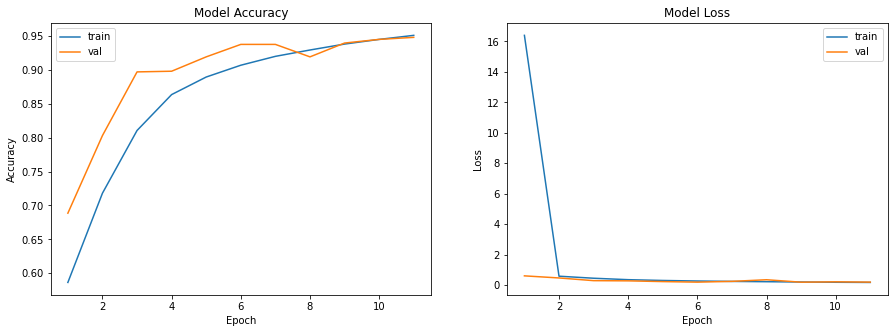

In [24]:
print('train loss:', history.history['loss'][-1])
print('train accuracy:', history.history['accuracy'][-1])

print('dev loss:', history.history['val_loss'][-1])
print('dev accuracy:', history.history['val_accuracy'][-1])

fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(range(1,len(history.history['accuracy'])+1), history.history['accuracy'])
axs[0].plot(range(1,len(history.history['val_accuracy'])+1),history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['train', 'val'], loc='best')

axs[1].plot(range(1,len(history.history['loss'])+1),history.history['loss'])
axs[1].plot(range(1,len(history.history['val_loss'])+1),history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['train', 'val'], loc='best')

plt.show()

In [ ]:
model.save('vgg.h5')

In [25]:
predictions = model.predict(x_test)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Ide

Executing op __inference_predict_function_161926 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_161926 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_161926 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_161926 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_161926 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_161926 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_161926 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_161926 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_161926 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_161926 in device /job:

Executing op __inference_predict_function_161926 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_161926 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_161926 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_161926 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_161926 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_161926 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_161926 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_161926 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_161926 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_predict_function_161926 in device /job:

In [26]:
print(predictions)

y_pred = []

for i in predictions:
    if i[0] < i[1]:
        y_pred.append(1)
    else:
        y_pred.append(0)

[[9.4296041e-08 9.9999988e-01]
 [1.0000000e+00 4.7188795e-29]
 [6.9426111e-04 9.9930573e-01]
 ...
 [7.8344010e-07 9.9999917e-01]
 [9.9998593e-01 1.4030659e-05]
 [3.6886752e-15 1.0000000e+00]]


In [27]:
from sklearn.metrics import confusion_matrix

confusion_mtx = confusion_matrix(y_test, y_pred)

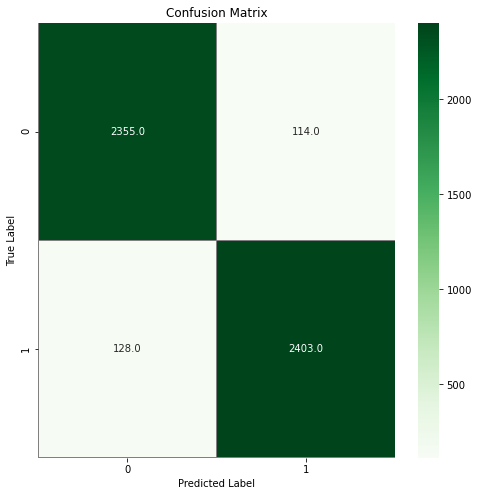

In [28]:
import seaborn as sns

f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Greens",linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [29]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=['cat', 'dog'])

In [30]:
print(report)

              precision    recall  f1-score   support

         cat       0.95      0.95      0.95      2469
         dog       0.95      0.95      0.95      2531

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000

